In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from rapidfuzz import fuzz

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('../data/titles_metadata_250702.csv', index_col=0)
df = df.head(6391)
df.shape

(6391, 9)

In [ ]:
# number of unique book advertisements
df['article_id'].nunique()

3705

In [ ]:
# top 20 most frequently advertised book titles
df.groupby(['author', 'cluster_label', 'category']).size().reset_index(name='count').sort_values(by='count', ascending=False).head(20)

,author,cluster_label,category,count
60,A. F. Just,Haandbog for den læsende Ungdom,Education and Bildung,55
540,C. Jacobsen,Nye Kogebog,"Agriculture, household and artisanship",46
977,F. Munthe,De vigtigste indenlandske Tildragelser og de m...,"History, philosophy and biographies",34
3827,Schou,Udtog af Forordninger,"Law, politics and government",27
69,A. F. Just,Naturhistorie,"Geography, topography and biology",25
26,A. F. Elmquist,Læsefrugter samlede paa Litteraturens Mark,Subscription journals,25
3543,P. O. Boisen,Bibelske Fortællinger med Anvendelse paa Relig...,"Religion, theology and psalms",21
976,F. Munthe,De mærkeligste Personers Levnetsbeskrivelse og...,"History, philosophy and biographies",18
498,C. F. Schulz,"Den lystige Lollænder, eller nyeste Samling af...",Almanacs and other light readings,17
1240,H. J. Birch,Bibelhistorie,"Religion, theology and psalms",17


In [ ]:
# authors that appear only once
df['author'].value_counts().eq(1).sum()

1049

In [73]:
# Exclude 'NO_AUTHOR'
filtered_df = df[df['author'] != 'NO_AUTHOR']

# Count mentions per author
filtered_df['author'].value_counts()

author
A. F. Just             144
Adam Oehlenschläger     81
J. L. Heiberg           81
A. F. Elmquist          75
A. von Kotzebue         67
                      ... 
Pastor Daugaard          1
P. Z. Anden              1
P. v. Gerschau           1
P. T. Hald               1
Niels Starup             1
Name: count, Length: 1705, dtype: int64

In [63]:
# number of unique book titles
df['cluster_label'].nunique()

3808

In [3]:
cat_names = df['category'].unique().tolist()

In [61]:
df['category'].value_counts()

category
Theatre, music and poems                  1310
Education and Bildung                      840
Religion, theology and psalms              811
Literature and personal writings           800
History, philosophy and biographies        609
Agriculture, household and artisanship     561
Law, politics and government               440
Almanacs and other light readings          431
Unknown                                    206
Subscription journals                      200
Geography, topography and biology          183
Name: count, dtype: int64

In [89]:
# Step 1: Count how many newspapers each book appears in
newspaper_counts = (
    df.groupby(['author', 'cluster_label'])['newspaper']
    .nunique()
    .reset_index(name='num_newspapers')
)

# Step 2: Keep only books that appear in 2 or more different newspapers
multi_newspaper_books = newspaper_counts[newspaper_counts['num_newspapers'] >= 2]

# Step 3: Merge back to get full rows for those books
df_multi = df.merge(
    multi_newspaper_books[['author', 'cluster_label']],
    on=['author', 'cluster_label'],
    how='inner'
)

# Step 4: Get the first ad for each book
first_mentions = (
    df_multi.sort_values('date')
    .groupby(['author', 'cluster_label'])
    .first()
    .reset_index()
)

# Step 5: Count how often each newspaper is the first to advertise
first_newspaper_counts = first_mentions['newspaper'].value_counts().reset_index()
first_newspaper_counts.columns = ['newspaper', 'count']

print(first_newspaper_counts)

  newspaper  count
0       ode    128
1       aar     94
2       aal     84
3       vib     70
4       lol     52
5       thi     33


In [119]:
first_newspaper_counts.sum()

newspaper    odeaaraalviblolthi
count                       461
dtype: object

In [102]:
# Step 1: For each (author, title), get the newspapers ordered by date
ad_paths = (
    df.sort_values('date')
    .groupby(['author', 'cluster_label'])['newspaper']
    .apply(lambda x: tuple(pd.unique(x)))  # keep order, remove duplicates
    .reset_index(name='path')
)

# Step 2: Count how often each unique path occurs
path_counts = ad_paths['path'].value_counts().reset_index()
path_counts.columns = ['path', 'count']

# Keep only paths with at least two different newspapers
multi_step_paths = path_counts[path_counts['path'].apply(len) >= 2].reset_index(drop=True)

In [ ]:
edge_rows = []

for _, row in multi_step_paths.iterrows():
    path = row['path']
    count = row['count']
    path_id = "_".join(path)
    for i in range(len(path) - 1):
        edge_rows.append({
            'Source': path[i],
            'Target': path[i + 1],
            'Weight': count,
            'PathID': path_id
        })

edges_df = pd.DataFrame(edge_rows)
edges_df.to_csv('../data/edges.csv', index=False)

In [ ]:
unique_nodes = set()
for path in multi_step_paths['path']:
    unique_nodes.update(path)

nodes_df = pd.DataFrame({'Id': sorted(unique_nodes)})
nodes_df['Label'] = nodes_df['Id']
nodes_df.to_csv('../data/nodes.csv', index=False)

#### Category sizes

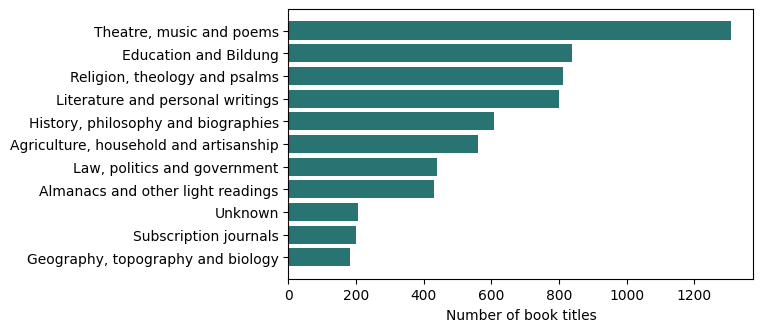

In [53]:
grouped1 = df['category'].value_counts()

fig, axs = plt.subplots(figsize=(6, 3.5))

axs.barh(range(len(grouped1)), grouped1.values[::-1], color='#297373')
axs.set_xlabel('Number of book titles')
axs.set_yticks(range(len(grouped1)))
axs.set_yticklabels(grouped1.index[::-1], ha='right')
#plt.title('Size of topic categories')
#plt.tight_layout()
plt.savefig('../figures/cat_sizes.pdf', bbox_inches='tight')
plt.show()

#### Normalized category distributions per newspaper

/var/folders/dt/1462j2zd19q_2sh2_66j7_8m6l1brz/T/ipykernel_64728/674466700.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Aalborg', 'Aarhus', 'Maribo', 'Odense', 'Thisted', 'Viborg'], ha='center')


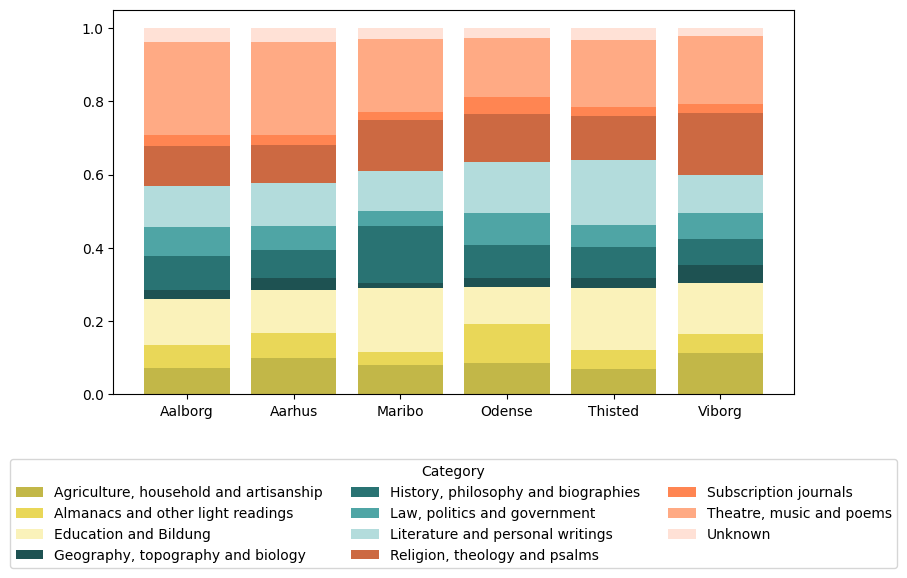

In [ ]:
# Group and count categories per newspaper
grouped = df.groupby(['newspaper', 'category']).size().unstack(fill_value=0)

# Normalize each row (per newspaper)
normalized = grouped.div(grouped.sum(axis=1), axis=0)

# Get a list of colors from the 'Paired' palette
custom_palette = [
    '#C2B748', '#E9D758', '#FAF2BA', #'#F2E480', #'#FAF2BA',  # yellows
    '#1E5252', '#297373', '#4FA5A5', '#B3DCDC',  # teals
    '#CC6942', '#FF8552', '#FFAA84', '#FFE1D6'   # corals
]

# Map categories to colors
category_to_color = dict(zip(normalized.columns, custom_palette))

# Plot
fig, ax = plt.subplots(figsize=(9, 6))

bottom = np.zeros(len(normalized))
for category in normalized.columns:
    ax.bar(
        normalized.index,
        normalized[category],
        bottom=bottom,
        label=category,
        color=category_to_color[category]
    )
    bottom += normalized[category]

#ax.set_ylabel("Proportion of Articles")
#ax.set_title("Normalized Category Distribution per Newspaper")
ax.set_xticklabels(['Aalborg', 'Aarhus', 'Maribo', 'Odense', 'Thisted', 'Viborg'], ha='center')

# One shared legend at the bottom
ax.legend(title="Category", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.savefig('../figures/norm_cats_newspapers.pdf', bbox_inches='tight')
plt.show()

### Comparison to author baseline

In [54]:
authors_baseline = pd.read_excel('../data/authors_baseline.xlsx')
authors_baseline.head()

,last_name,first_name,Unnamed: 2
0,a Fincke,Matthæus,NaN
1,Aabye,Thomas,NaN
2,Aagaard,Andreas Jensen,NaN
3,Aagaard,Christen Lauridsen,NaN
4,Aagaard,Christen Rømer,NaN


In [57]:
authors_baseline['full_name'] = authors_baseline['first_name'] + ' ' + authors_baseline['last_name']

In [58]:
authors_baseline.head()

,last_name,first_name,Unnamed: 2,full_name
0,a Fincke,Matthæus,NaN,Matthæus a Fincke
1,Aabye,Thomas,NaN,Thomas Aabye
2,Aagaard,Andreas Jensen,NaN,Andreas Jensen Aagaard
3,Aagaard,Christen Lauridsen,NaN,Christen Lauridsen Aagaard
4,Aagaard,Christen Rømer,NaN,Christen Rømer Aagaard


In [66]:
df['author'].nunique()

1706

In [75]:
def clean_name(name):
    """Normalize whitespace and casing"""
    return re.sub(r'\s+', ' ', name).strip().lower()

def extract_initials_and_surname(name):
    """Extract initials and surname from abbreviated name"""
    parts = name.strip().split()
    initials = [p[0] for p in parts if '.' in p]
    surname = parts[-1]
    return initials, clean_name(surname)

def match_name(query, full_name, fuzzy_threshold=80, surname_threshold=80):
    if not isinstance(query, str) or not isinstance(full_name, str):
        return False

    query = clean_name(query)
    full_name = clean_name(full_name)

    query_parts = query.split()
    full_parts = full_name.split()

    full_surname = full_parts[-1]
    full_given = full_parts[:-1]

    # Case 1: only surname
    if len(query_parts) == 1:
        score = fuzz.ratio(query, full_surname)
        return score >= surname_threshold

    # Case 2: initials + surname
    if any('.' in p for p in query_parts):
        initials, query_surname = extract_initials_and_surname(query)
        if len(initials) > len(full_given):
            return False
        # initials must match exactly
        if not all(full_given[i].startswith(initials[i]) for i in range(len(initials))):
            return False
        # fuzzy match on surname
        score = fuzz.ratio(query_surname, full_surname)
        return score >= surname_threshold

    # Case 3: full name → fuzzy match on full name
    similarity = fuzz.token_sort_ratio(query, full_name)
    return similarity >= fuzzy_threshold

In [76]:
author_list = authors_baseline['full_name'].dropna().tolist()
df['author'] = df['author'].fillna('')

df['is_match'] = df['author'].apply(
    lambda x: any(match_name(x, name) for name in author_list)
)

# Optional: get number of matches
num_matches = df['is_match'].sum()
print(f"{num_matches} out of {len(df)} authors matched.")

3175 out of 6391 authors matched.


In [77]:
df.groupby('is_match')['author'].nunique()

is_match
False    851
True     855
Name: author, dtype: int64

### Book titles per month

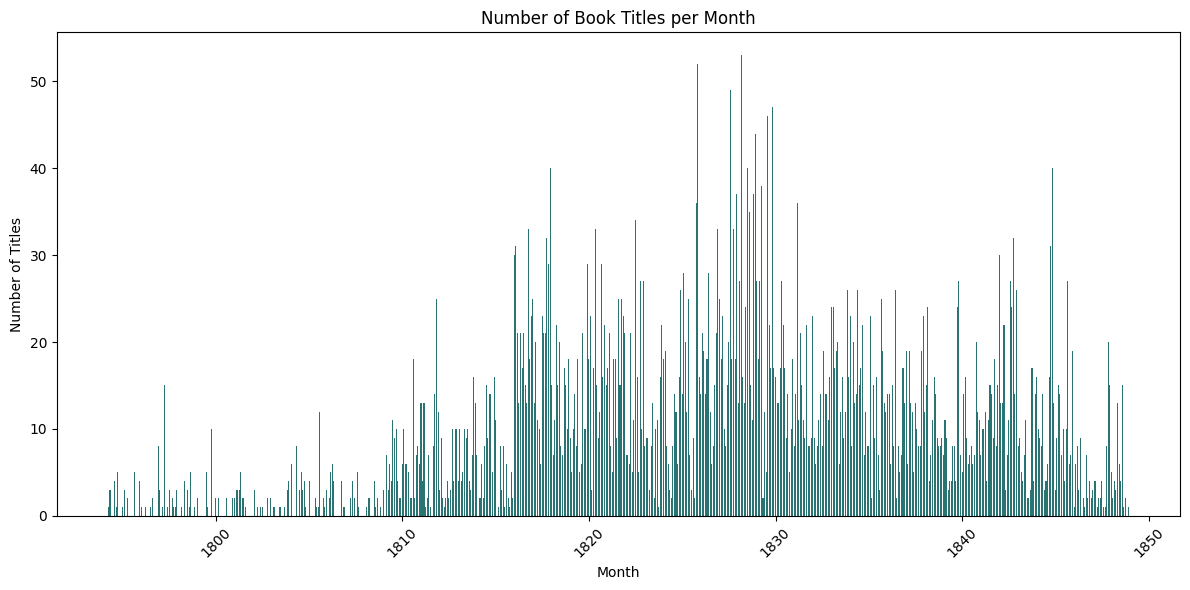

In [5]:
# Ensure 'date' column is datetime
df['date'] = pd.to_datetime(df['date'])

# Create 'month' column (year + month only)
df['month'] = df['date'].dt.to_period('M')

# Count number of titles per month
monthly_counts = df.groupby('month').size()

# Convert PeriodIndex to datetime for plotting
monthly_counts.index = monthly_counts.index.to_timestamp()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(monthly_counts.index, monthly_counts.values, width=20, color='#297373')
#plt.xlim(pd.to_datetime('1824-01-01'), pd.to_datetime('1838-12-31'))
plt.xlabel('Month')
plt.ylabel('Number of Titles')
plt.title('Number of Book Titles per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Longevity of books and authors

In [12]:
# Group by title and calculate min and max date
date_spans = df.groupby('cluster_label')['date'].agg(['min', 'max'])

# Calculate the number of days between first and last mention
date_spans['days_between'] = (date_spans['max'] - date_spans['min']).dt.days

# Optional: sort by longest running titles
date_spans = date_spans.sort_values(by='days_between', ascending=False)

In [10]:
date_spans.head(30)

,min,max,days_between
cluster_label,,,
Digte,1794-08-30,1840-10-23,16855
Naturhistorie,1796-12-07,1842-11-17,16780
Nyeaarsgave for 1797,1797-01-04,1836-12-27,14601
Geometrie,1797-04-29,1835-06-04,13914
Bibliothek for Læger,1809-08-24,1847-02-18,13692
Psalmebog,1803-11-16,1840-04-22,13307
Huuspostil,1811-03-05,1847-06-15,13251
Psalmebøger,1809-01-07,1842-09-17,12306
Haandbog for den læsende Ungdom,1800-03-12,1833-08-16,12210


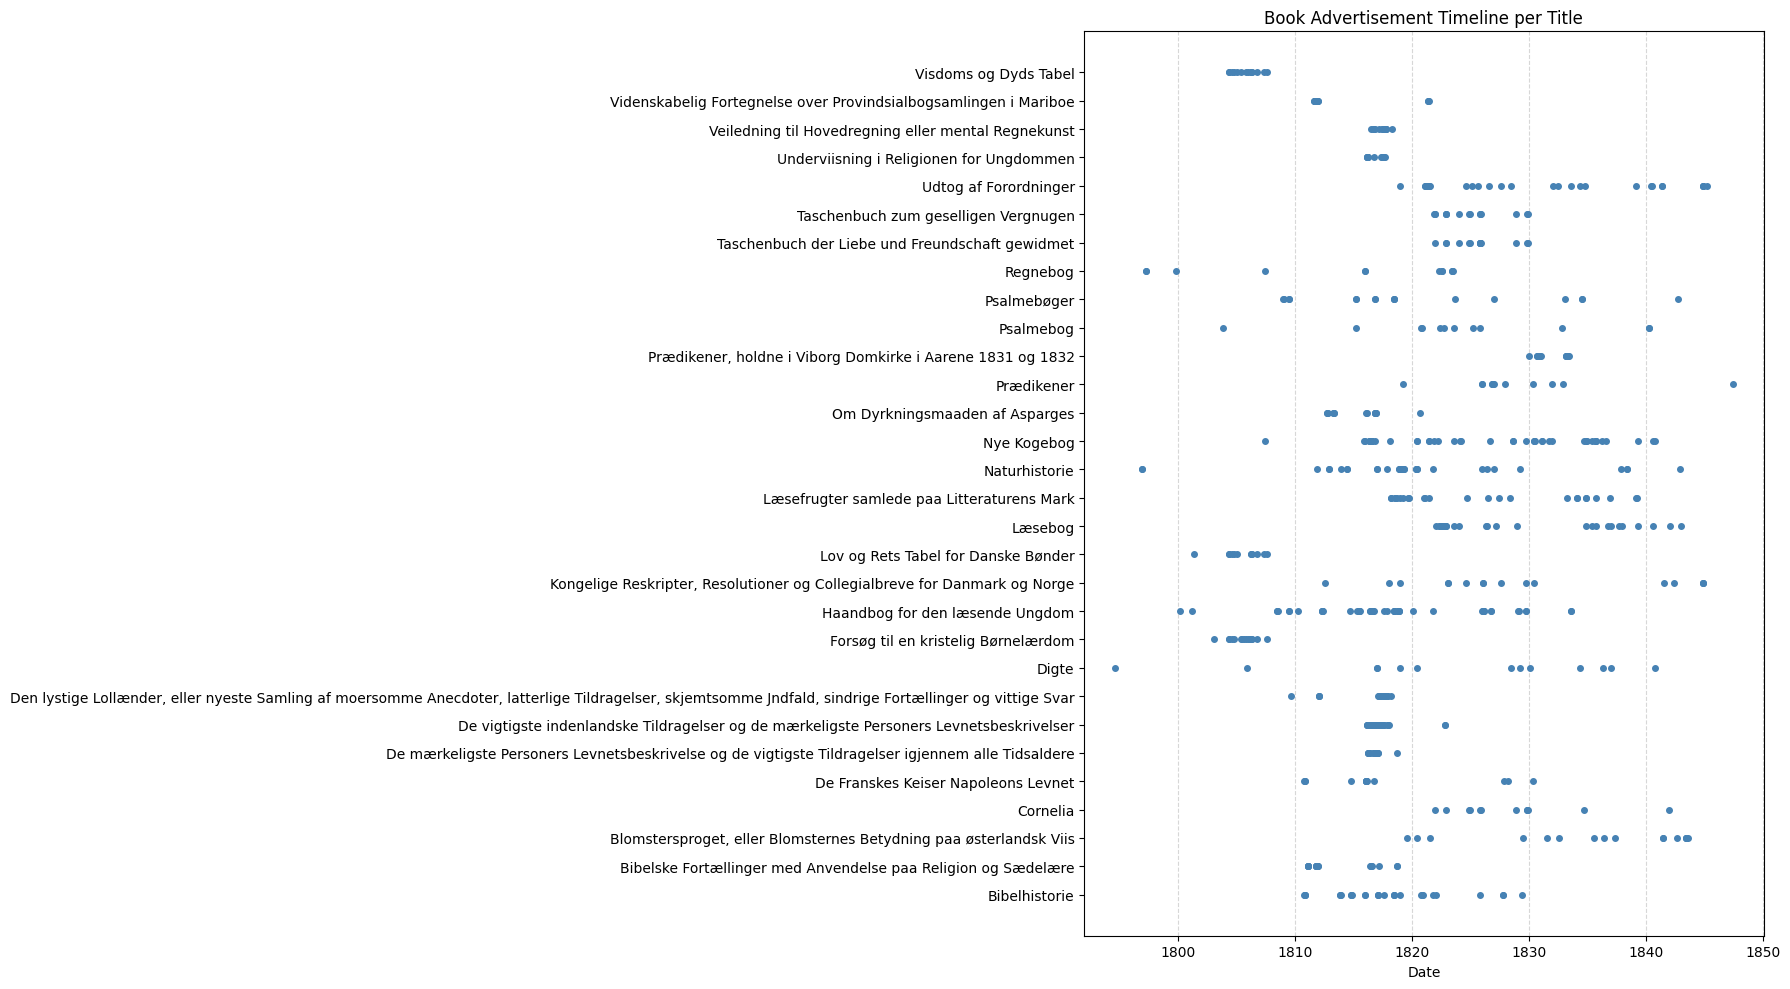

In [18]:
# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Optional: limit to top N most advertised books for clarity
top_titles = df['cluster_label'].value_counts().head(30).index
df_subset = df[df['cluster_label'].isin(top_titles)].copy()

# Sort titles for consistent vertical positioning
title_order = sorted(df_subset['cluster_label'].unique())
title_to_y = {title: i for i, title in enumerate(title_order)}

# Create the plot
plt.figure(figsize=(18, 10))

# Plot each appearance as a dot
for _, row in df_subset.iterrows():
    y = title_to_y[row['cluster_label']]
    plt.plot(row['date'], y, 'o', color='steelblue', markersize=4)

# Customize axes
plt.yticks(range(len(title_order)), title_order)
plt.xlabel('Date')
plt.title('Book Advertisement Timeline per Title')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [19]:
# Group by title and category → get min and max date per title
lifespans = df.groupby(['cluster_label', 'category'])['date'].agg(['min', 'max'])

# Compute number of days between first and last mention
lifespans['lifespan_days'] = (lifespans['max'] - lifespans['min']).dt.days

# Group by category and compute average lifespan
avg_lifespan_per_category = lifespans.groupby('category')['lifespan_days'].mean().round(1)

# Display result
print(avg_lifespan_per_category)

category
Agriculture, household and artisanship    414.0
Almanacs and other light readings         585.4
Education and Bildung                     571.7
Geography, topography and biology         451.7
History, philosophy and biographies       192.7
Law, politics and government              342.9
Literature and personal writings          220.4
Religion, theology and psalms             602.1
Subscription journals                     541.3
Theatre, music and poems                  498.6
Unknown                                    35.7
Name: lifespan_days, dtype: float64


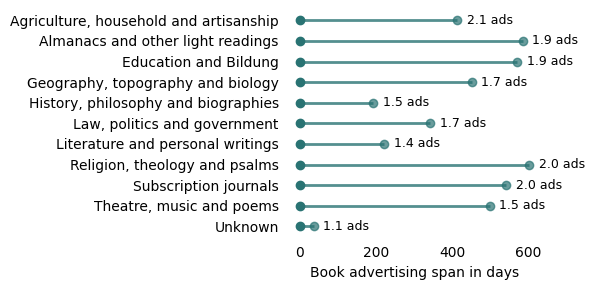

In [58]:
# Group by title and category
grouped = df.groupby(['cluster_label', 'category'])

# Calculate lifespan and ad count per book
book_stats = grouped['date'].agg(['min', 'max', 'count']).reset_index()
book_stats['lifespan'] = (book_stats['max'] - book_stats['min']).dt.days

# Average per category
category_stats = book_stats.groupby('category').agg(
    avg_lifespan=('lifespan', 'mean'),
    avg_ads=('count', 'mean')
).reset_index()

# Sort categories for clear plot
category_stats = category_stats.sort_values(by='category', ascending=False).reset_index(drop=True)

# Plot
fig, ax = plt.subplots(figsize=(6, 3))

for i, row in category_stats.iterrows():
    y = i
    ax.hlines(y, 0, row['avg_lifespan'], color='#297373', linewidth=2, linestyles='solid', alpha=0.8)
    ax.plot(0, y, 'o', color='#297373')  # Start at 0
    ax.plot(row['avg_lifespan'], y, 'o', color='#297373', alpha=0.7)  # End at lifespan
    ax.text(row['avg_lifespan'] + 15, y, f" {row['avg_ads']:.1f} ads", va='center', fontsize=9)

# Labels and formatting
ax.set_yticks(range(len(category_stats)))
ax.set_yticklabels(category_stats['category'])
ax.set_xlabel("Book advertising span in days")
#ax.set_title("Average Book Lifespan per Category\n(Green = first appearance, Red = last)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(left=False)
ax.tick_params(bottom=False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig('../figures/lifespan_books.pdf', bbox_inches='tight')
plt.show()

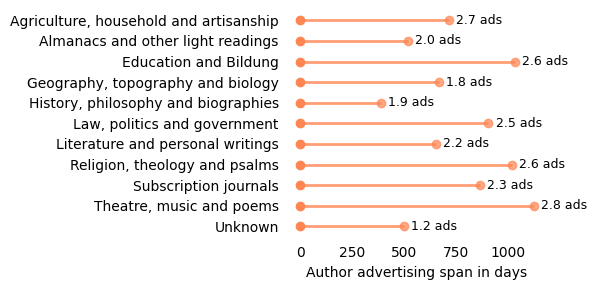

In [60]:
# Group by title and category
df_no_author = df[df['author'] != 'NO_AUTHOR']
grouped_authors = df_no_author.groupby(['author', 'category'])

# Calculate lifespan and ad count per book
book_stats = grouped_authors['date'].agg(['min', 'max', 'count']).reset_index()
book_stats['lifespan'] = (book_stats['max'] - book_stats['min']).dt.days

# Average per category
category_stats = book_stats.groupby('category').agg(
    avg_lifespan=('lifespan', 'mean'),
    avg_ads=('count', 'mean')
).reset_index()

# Sort categories for clear plot
category_stats = category_stats.sort_values(by='category', ascending=False).reset_index(drop=True)

# Plot
fig, ax = plt.subplots(figsize=(6, 3))

for i, row in category_stats.iterrows():
    y = i
    ax.hlines(y, 0, row['avg_lifespan'], color='#FF8552', linewidth=2, linestyles='solid', alpha=0.8)
    ax.plot(0, y, 'o', color='#FF8552')  # Start at 0
    ax.plot(row['avg_lifespan'], y, 'o', color='#FF8552', alpha=0.7)  # End at lifespan
    ax.text(row['avg_lifespan'] + 15, y, f" {row['avg_ads']:.1f} ads", va='center', fontsize=9)

# Labels and formatting
ax.set_yticks(range(len(category_stats)))
ax.set_yticklabels(category_stats['category'])
ax.set_xlabel("Author advertising span in days")
#ax.set_title("Average Book Lifespan per Category\n(Green = first appearance, Red = last)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(left=False)
ax.tick_params(bottom=False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig('../figures/lifespan_authors.pdf', bbox_inches='tight')
plt.show()

### Modeling, second attempt

In [122]:
# Make sure 'year' is a separate column (if not already)
df['year'] = pd.to_datetime(df['date']).dt.year

# Group and count
counts = df.groupby(['newspaper', 'year', 'category']).size().reset_index(name='count')

In [131]:
nsp_counts = pd.read_csv('../data/nsp_counts.csv', index_col=0)
nsp_counts

,newspaper,year,count_nsp
0,aal,1818,150
1,aal,1819,158
2,aal,1820,152
3,aal,1821,163
4,aal,1822,163
...,...,...,...
200,vib,1838,164
201,vib,1839,189
202,vib,1840,209
203,vib,1841,210


In [123]:
counts

,newspaper,year,category,count
0,aal,1818,Almanacs and other light readings,2
1,aal,1818,Education and Bildung,8
2,aal,1818,"Geography, topography and biology",2
3,aal,1818,"History, philosophy and biographies",4
4,aal,1818,"Law, politics and government",3
...,...,...,...,...
1529,vib,1842,Literature and personal writings,11
1530,vib,1842,"Religion, theology and psalms",3
1531,vib,1842,Subscription journals,4
1532,vib,1842,"Theatre, music and poems",14


#### Compute normalized counts of book titles in category per newspaper per year

In [126]:
# Step 3: Merge on 'newspaper' and 'year'
merged = counts.merge(nsp_counts, on=['newspaper', 'year'], how='left')

# Step 4: Normalize the counts
merged['normalized_count'] = merged['count'] / merged['count_nsp']

merged

,newspaper,year,category,count,count_nsp,normalized_count
0,aal,1818,Almanacs and other light readings,2,150,0.013333
1,aal,1818,Education and Bildung,8,150,0.053333
2,aal,1818,"Geography, topography and biology",2,150,0.013333
3,aal,1818,"History, philosophy and biographies",4,150,0.026667
4,aal,1818,"Law, politics and government",3,150,0.020000
...,...,...,...,...,...,...
1529,vib,1842,Literature and personal writings,11,205,0.053659
1530,vib,1842,"Religion, theology and psalms",3,205,0.014634
1531,vib,1842,Subscription journals,4,205,0.019512
1532,vib,1842,"Theatre, music and poems",14,205,0.068293


In [133]:
# cities

cities = pd.read_csv('../data/cities.csv')
cities

,nsp,City,Population,Accessibility
0,aal,Aalborg,6500,102
1,aar,Aarhus,6000,78
2,lol,Maribo,1000,30
3,ode,Odense,8000,33
4,thi,Thisted,1600,109
5,vib,Viborg,3100,85


In [142]:
# Linear regression

# X = (population)
# y = number of titles in a city

total_titles = merged.groupby('newspaper')['normalized_count'].sum().reset_index(name='total_titles')

In [140]:
mean_titles = total_titles.mean()

In [148]:
mean_titles

7.106654341442678

In [149]:
mean_population = cities['Population'].mean()

#### Number of book advertisements dependent on population and accessiblility

In [ ]:
# Define X and y
X = cities[['Population','Accessibility']]
y = total_titles['total_titles']

# split up per year and add year as random effect
# mixed effects model
# correlation between titles and population

# logisitc regression with time as a random effect

# Option 1: sklearn
model = LinearRegression()
model.fit(X, y)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R² score:", model.score(X, y))

# Option 2: statsmodels for detailed output
X_sm = sm.add_constant(X)
ols_model = sm.OLS(y, X_sm).fit()
print(ols_model.summary())

Coefficients: [-0.00019942 -0.0538996 ]
Intercept: 11.903153622022092
R² score: 0.7984706816702806
                            OLS Regression Results                            
Dep. Variable:           total_titles   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     5.943
Date:                Wed, 09 Jul 2025   Prob (F-statistic):             0.0905
Time:                        11:54:52   Log-Likelihood:                -7.5732
No. Observations:                   6   AIC:                             21.15
Df Residuals:                       3   BIC:                             20.52
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [154]:
# Desired intercept (e.g. average number of titles)
custom_intercept = y.mean()

# Re-center y to set the intercept manually
y_centered = y - custom_intercept

# Add constant manually as zero (since intercept is fixed)
X_sm = sm.add_constant(X, has_constant='add')

# Fit OLS on centered y without letting statsmodels fit the intercept
model = sm.OLS(y_centered, X_sm).fit()

# Extract slope and manually re-add the intercept
slope = model.params[1]  # assuming 'Population' is the first variable
print("Custom intercept (manually set):", custom_intercept)
print("Slope:", slope)

# Optional: predict with custom intercept
y_pred = model.predict(X_sm) + custom_intercept

Custom intercept (manually set): 7.106654341442678
Slope: -0.0001994224941716668


/var/folders/dt/1462j2zd19q_2sh2_66j7_8m6l1brz/T/ipykernel_1589/910956077.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]  # assuming 'Population' is the first variable


#### Education and Bildung dependent on population and accessibility

In [157]:
education_only = merged[merged['category'] == 'Education and Bildung']

education_titles = (
    education_only
    .groupby('newspaper')['normalized_count']
    .sum()
    .reset_index(name='education_titles')
)

In [159]:
education_titles

,newspaper,education_titles
0,aal,0.611599
1,aar,1.014473
2,lol,1.858443
3,ode,0.754297
4,thi,0.857515
5,vib,0.873614


In [161]:
X = cities[['Population', 'Accessibility']]
y = education_titles['education_titles']

# Option 1: sklearn
model = LinearRegression()
model.fit(X, y)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R² score:", model.score(X, y))

# Option 2: statsmodels for detailed output
X_sm = sm.add_constant(X)
ols_model = sm.OLS(y, X_sm).fit()
print(ols_model.summary())

Coefficients: [-0.00010791 -0.00865696]
Intercept: 2.096730183893782
R² score: 0.8371916597774332
                            OLS Regression Results                            
Dep. Variable:       education_titles   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     7.713
Date:                Wed, 09 Jul 2025   Prob (F-statistic):             0.0657
Time:                        12:04:17   Log-Likelihood:                 2.3541
No. Observations:                   6   AIC:                             1.292
Df Residuals:                       3   BIC:                            0.6671
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


### Modeling, first attempt

In [84]:
df_filtered = df[(df['date'] >= '1824-01-01') & (df['date'] <= '1838-12-31')]
df_filtered.shape

(2922, 10)

In [85]:
df_filtered.head()

,article_id,author,clean_title,cluster_label,category,Nationality,date,newspaper,month,is_match
1480.0,thi_008383,A. C. Gudne,Anviisning til et Dampfiskeries Anlæg og Fiskeaal,Anviisning til et Dampfiskeries Anlæg og Fiskeaal,"Agriculture, household and artisanship",NaN,1828-03-14,thi,1828-03,False
5653.0,ode_078428,A. D. Thortsen,"Veiledning for de, som bestemme sig til Handelen","Veiledning for de, som bestemme sig til Handelen","Agriculture, household and artisanship",NaN,1826-04-14,ode,1826-04,False
1040.0,aal_072184,A. F. Elmquist,"Blomstersproget, eller Blomsternes Betydning p...","Blomstersproget, eller Blomsternes Betydning p...","Agriculture, household and artisanship",NaN,1829-06-20,aal,1829-06,True
1041.0,aar_165609,A. F. Elmquist,"Blomstersproget, eller Blomsternes Betydning p...","Blomstersproget, eller Blomsternes Betydning p...","Agriculture, household and artisanship",NaN,1837-05-20,aar,1837-05,True
1042.0,aal_092054,A. F. Elmquist,"Blomstersproget, eller Blomsternes Betydning p...","Blomstersproget, eller Blomsternes Betydning p...","Agriculture, household and artisanship",NaN,1832-08-06,aal,1832-08,True


In [121]:
df_filtered['newspaper'].value_counts()

newspaper
ode    737
thi    551
aal    506
lol    423
aar    411
vib    294
Name: count, dtype: int64

In [86]:
# Make sure 'year' is a separate column (if not already)
df_filtered['year'] = pd.to_datetime(df_filtered['date']).dt.year

# Group and count
counts = df_filtered.groupby(['newspaper', 'year', 'category']).size().reset_index(name='count')

/var/folders/dt/1462j2zd19q_2sh2_66j7_8m6l1brz/T/ipykernel_64728/1588699410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year'] = pd.to_datetime(df_filtered['date']).dt.year


In [87]:
counts

,newspaper,year,category,count
0,aal,1824,"Agriculture, household and artisanship",7
1,aal,1824,Almanacs and other light readings,7
2,aal,1824,Education and Bildung,3
3,aal,1824,"History, philosophy and biographies",5
4,aal,1824,Literature and personal writings,9
...,...,...,...,...
697,vib,1838,"Geography, topography and biology",2
698,vib,1838,"Law, politics and government",4
699,vib,1838,"Religion, theology and psalms",1
700,vib,1838,"Theatre, music and poems",17


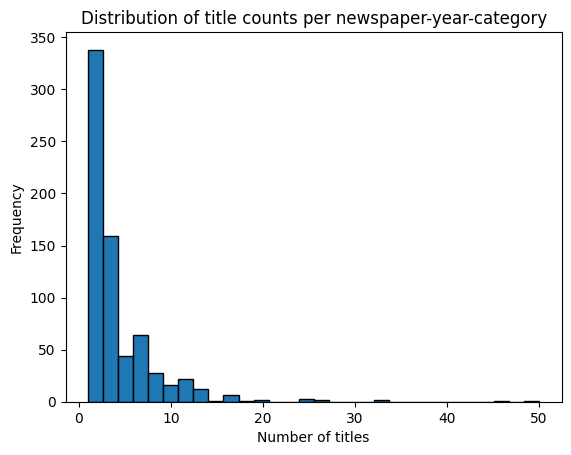

In [88]:
plt.hist(counts['count'], bins=30, edgecolor='black')
plt.xlabel('Number of titles')
plt.ylabel('Frequency')
plt.title('Distribution of title counts per newspaper-year-category')
plt.show()

In [90]:
counts['count'].describe()

count    702.000000
mean       4.162393
std        4.755579
min        1.000000
25%        1.000000
50%        3.000000
75%        5.000000
max       50.000000
Name: count, dtype: float64

In [91]:
bin_edges = [0, 10, 20, 30, 40, float('inf')]
bin_labels = [0, 1, 2, 3, 4]

counts['ordinal_level'] = pd.cut(counts['count'], bins=bin_edges, labels=bin_labels, right=False)

In [92]:
level_names = {
    0: 'Rare',
    1: 'Occasional',
    2: 'Moderate',
    3: 'Frequent',
    4: 'Dominant'
}

counts['level_name'] = counts['ordinal_level'].map(level_names)

In [93]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [96]:
X = pd.get_dummies(counts[['category', 'newspaper', 'year']], drop_first=True)

In [98]:
X = X.astype(float)
X

,year,category_Almanacs and other light readings,category_Education and Bildung,"category_Geography, topography and biology","category_History, philosophy and biographies","category_Law, politics and government",category_Literature and personal writings,"category_Religion, theology and psalms",category_Subscription journals,"category_Theatre, music and poems",category_Unknown,newspaper_aar,newspaper_lol,newspaper_ode,newspaper_thi,newspaper_vib
0,1824.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1824.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1824.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1824.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1824.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,1838.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
698,1838.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
699,1838.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
700,1838.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [99]:
model = OrderedModel(
    endog=counts['ordinal_level'],
    exog=X,
    distr='logit'
)

result = model.fit()
print(result.summary())

                             OrderedModel Results                             
Dep. Variable:          ordinal_level   Log-Likelihood:                -258.89
Model:                   OrderedModel   AIC:                             557.8
Method:            Maximum Likelihood   BIC:                             648.9
Date:                Thu, 03 Jul 2025                                         
Time:                        10:15:19                                         
No. Observations:                 702                                         
Df Residuals:                     682                                         
Df Model:                          16                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
year                                             0.0003      0.

/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [100]:
counts_all = df_filtered.groupby(['newspaper', 'category']).size().reset_index(name='count')
counts_all

,newspaper,category,count
0,aal,"Agriculture, household and artisanship",41
1,aal,Almanacs and other light readings,26
2,aal,Education and Bildung,57
3,aal,"Geography, topography and biology",12
4,aal,"History, philosophy and biographies",37
...,...,...,...
61,vib,Literature and personal writings,28
62,vib,"Religion, theology and psalms",36
63,vib,Subscription journals,11
64,vib,"Theatre, music and poems",82


In [114]:
# Step 1: Count total number of titles per newspaper
total_per_newspaper = df_filtered.groupby('newspaper').size().reset_index(name='total_count')

# Step 2: Count titles per newspaper × category
counts_all = df_filtered.groupby(['newspaper', 'category']).size().reset_index(name='count')

# Step 3: Merge total counts into the category counts
counts_all = counts_all.merge(total_per_newspaper, on='newspaper')

# Step 4: Compute share (normalized count)
counts_all['share'] = counts_all['count'] / counts_all['total_count']

In [108]:
counts_all['newspaper'].unique()

array(['aal', 'aar', 'lol', 'ode', 'thi', 'vib'], dtype=object)

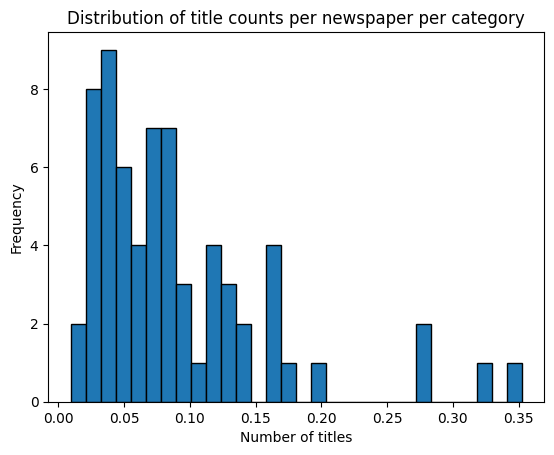

In [115]:
plt.hist(counts_all['share'], bins=30, edgecolor='black')
plt.xlabel('Number of titles')
plt.ylabel('Frequency')
plt.title('Distribution of title counts per newspaper per category')
plt.show()

In [127]:
X = pd.get_dummies(counts_all[['newspaper', 'category']], drop_first=True)
y = counts_all['count']

X = X.astype(float)
X

,newspaper_aar,newspaper_lol,newspaper_ode,newspaper_thi,newspaper_vib,category_Almanacs and other light readings,category_Education and Bildung,"category_Geography, topography and biology","category_History, philosophy and biographies","category_Law, politics and government",category_Literature and personal writings,"category_Religion, theology and psalms",category_Subscription journals,"category_Theatre, music and poems",category_Unknown
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
63,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
64,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [129]:
import statsmodels.api as sm

X = sm.add_constant(X)  # Add intercept
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     13.07
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           1.94e-12
Time:                        11:42:12   Log-Likelihood:                -276.66
No. Observations:                  66   AIC:                             585.3
Df Residuals:                      50   BIC:                             620.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [131]:
import statsmodels.formula.api as smf

model = smf.ols('count ~ C(newspaper) * C(category)', data=counts_all).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 03 Jul 2025   Prob (F-statistic):                nan
Time:                        11:44:25   Log-Likelihood:                 1830.6
No. Observations:                  66   AIC:                            -3529.
Df Residuals:                       0   BIC:                            -3385.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [ ]:
# count (theater) 


In [133]:
counts_theatre = counts_all[counts_all['category'] == 'Theatre, music and poems']
counts_theatre.shape

(6, 5)

In [134]:
X = pd.get_dummies(counts_theatre['newspaper'], drop_first=True)
y = counts_theatre['count']

X = X.astype(float)
X

,aar,lol,ode,thi,vib
9,0.0,0.0,0.0,0.0,0.0
20,1.0,0.0,0.0,0.0,0.0
31,0.0,1.0,0.0,0.0,0.0
42,0.0,0.0,1.0,0.0,0.0
53,0.0,0.0,0.0,1.0,0.0
64,0.0,0.0,0.0,0.0,1.0


In [135]:
X = sm.add_constant(X)  # Add intercept
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 03 Jul 2025   Prob (F-statistic):                nan
Time:                        11:58:30   Log-Likelihood:                 175.89
No. Observations:                   6   AIC:                            -339.8
Df Residuals:                       0   BIC:                            -341.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        140.0000        inf          0        n

/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [136]:
counts_theatre

,newspaper,category,count,total_count,share
9,aal,"Theatre, music and poems",140,506,0.276680
20,aar,"Theatre, music and poems",135,411,0.328467
31,lol,"Theatre, music and poems",149,423,0.352246
42,ode,"Theatre, music and poems",119,737,0.161465
53,thi,"Theatre, music and poems",92,551,0.166969
64,vib,"Theatre, music and poems",82,294,0.278912


In [158]:
counts_selection = counts_all[counts_all['newspaper'].isin(['aal', 'aar', 'lol', 'ode', 'thi', 'vib'])]

In [161]:
# Step 1: Set baseline
counts_selection['newspaper'] = pd.Categorical(
    counts_selection['newspaper'],
    categories=['lol', 'vib', 'aal', 'aar', 'ode', 'thi'],  # baseline = 'vib'
    ordered=True
)

In [162]:
X = pd.get_dummies(counts_selection['newspaper'], drop_first=True)
y = counts_selection['count']

X = X.astype(float)

X = sm.add_constant(X)  # Add intercept
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     1.709
Date:                Thu, 03 Jul 2025   Prob (F-statistic):              0.146
Time:                        12:19:10   Log-Likelihood:                -324.85
No. Observations:                  66   AIC:                             661.7
Df Residuals:                      60   BIC:                             674.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.4545     10.504      3.661      0.0

In [165]:
counts_really_all = df.groupby(['newspaper', 'category']).size().reset_index(name='count')

In [267]:
category_shares = counts_really_all.copy()

# Group by newspaper and compute total per newspaper
category_shares['total_in_paper'] = category_shares.groupby('newspaper')['count'].transform('sum')

# Compute category share within each newspaper
category_shares['category_share'] = category_shares['count'] / category_shares['total_in_paper']

In [ ]:
custom_palette2 = [
     '#E9D758', '#FAF2BA', # yellows
     '#297373', '#4FA5A5', # teals
   '#FF8552', '#FFAA84' # corals
]

legend_labels = {'aal': 'Aalborg',
                 'aar': 'Aarhus',
                 'lol': 'Maribo',
                 'ode': 'Odense',
                 'thi': 'Thisted',
                 'vib': 'Viborg'}

# Map categories to colors
# Make sure each newspaper maps to a unique color
unique_newspapers = category_shares['newspaper'].unique()
newspaper_to_color = dict(zip(unique_newspapers, custom_palette2))

#### Make a PCA of the newspaper category distributions

In [ ]:
# Step 1: Pivot so each newspaper is a row, and each column is a category_share
pivot_df = category_shares.pivot(index='newspaper', columns='category', values='category_share').fillna(0)

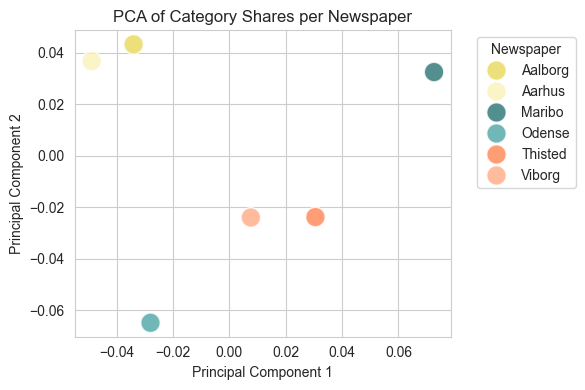

In [272]:
# Step 3: Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivot_df)

# Step 4: Plot
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=pivot_df.index)

plt.figure(figsize=(6, 4))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='newspaper', palette=newspaper_to_color, s=200, alpha=0.8)

# Annotate with newspaper names
#for index, row in pca_df.iterrows():
    #plt.text(row['PC1'], row['PC2'], index, fontsize=9)

plt.title('PCA of Category Shares per Newspaper')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Get original handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Replace labels with custom ones
custom_labels = [legend_labels[label] for label in labels]

# Apply updated legend
plt.legend(handles, custom_labels, title='Newspaper', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend([unique_newspapers])
plt.grid(True)
plt.tight_layout()
plt.show()

In [198]:
# simulate 100 extra data points with the same mean and std for each newspaper

simulated_data = []

for newspaper in pivot_df.index:
    mean_vec = pivot_df.loc[newspaper].values
    std_vec = pivot_df.loc[newspaper].std()

    # Simulate 100 samples per newspaper from a multivariate normal
    # Use a diagonal covariance matrix (no correlation between categories)
    cov = np.diag([std_vec] * len(mean_vec))  # simple isotropic assumption
    samples = np.random.normal(loc=mean_vec, scale=std_vec, size=(100, len(mean_vec)))

    for sample in samples:
        simulated_data.append({
            'newspaper': newspaper,
            **{cat: val for cat, val in zip(pivot_df.columns, sample)}
        })

# 2. Convert to DataFrame
simulated_df = pd.DataFrame(simulated_data)

In [274]:
simulated_df_indexed = simulated_df.set_index('newspaper')

In [275]:
total_df = pd.concat([pivot_df, simulated_df_indexed])

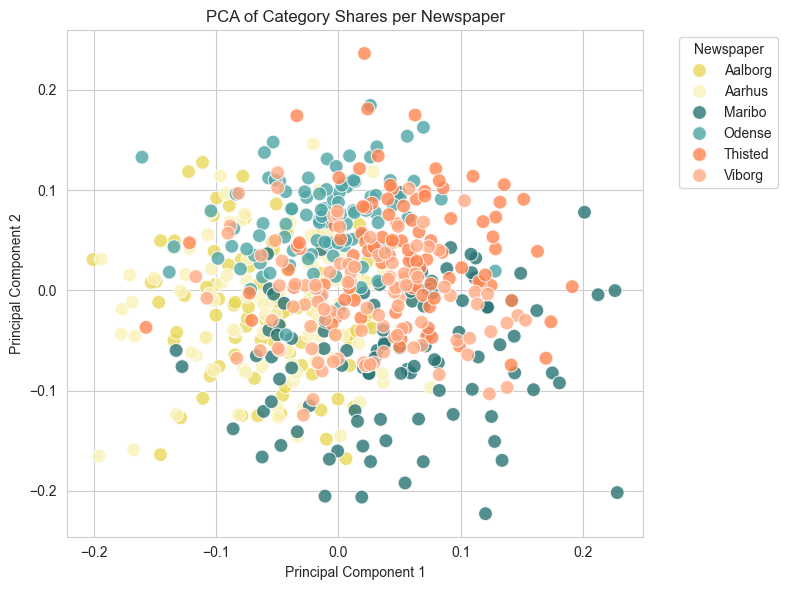

In [277]:
# Step 3: Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(total_df)

# Step 4: Plot
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=total_df.index)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='newspaper', palette=newspaper_to_color, s=100, alpha=0.8)

# Annotate with newspaper names
#for index, row in pca_df.iterrows():
    #plt.text(row['PC1'], row['PC2'], index, fontsize=9)

plt.title('PCA of Category Shares per Newspaper')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Get original handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Replace labels with custom ones
custom_labels = [legend_labels[label] for label in labels]

# Apply updated legend
plt.legend(handles, custom_labels, title='Newspaper', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend([unique_newspapers])
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# dendrogram
# jensen shannon

/var/folders/dt/1462j2zd19q_2sh2_66j7_8m6l1brz/T/ipykernel_1589/1989094767.py:12: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(cosine_dist_matrix, method='ward')


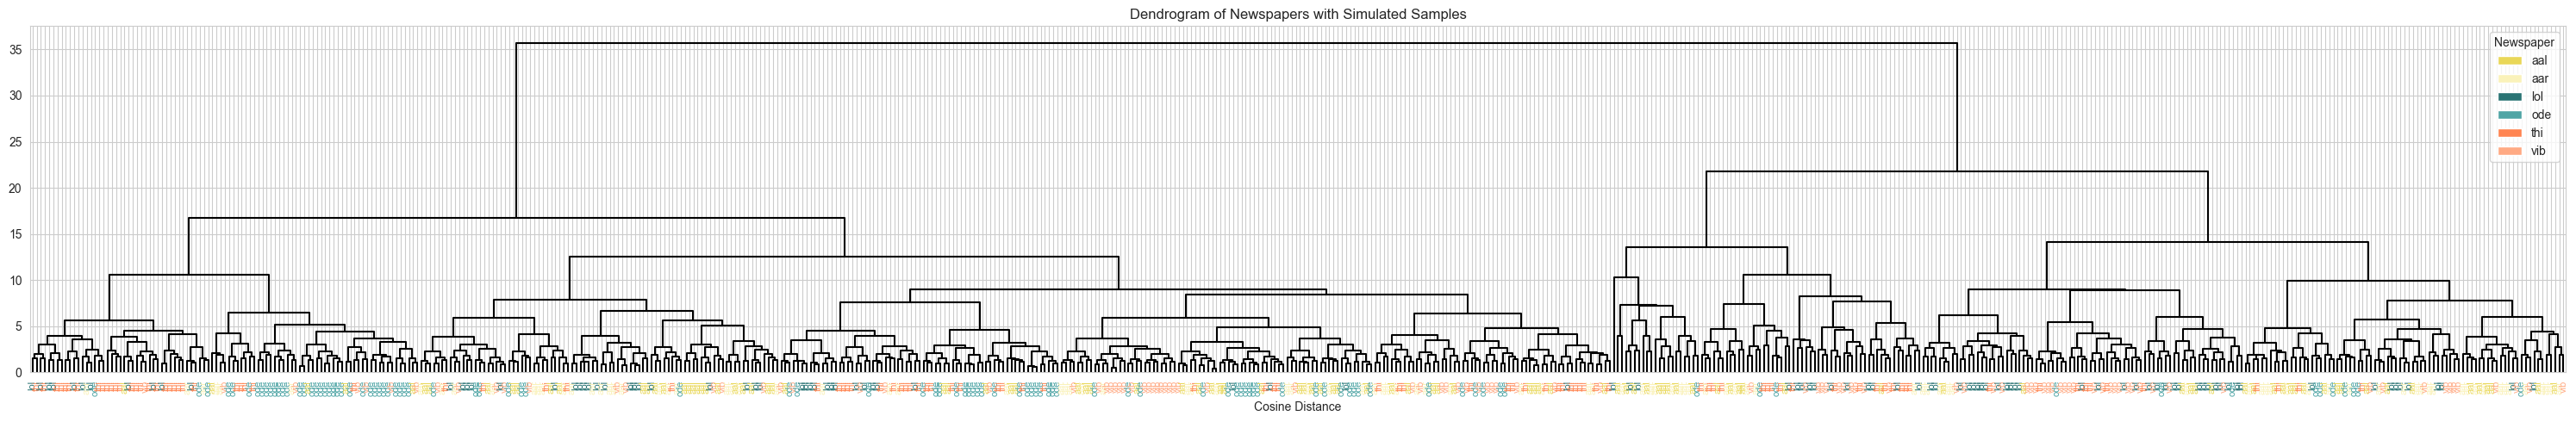

In [278]:
def plot_newspaper_dendrogram(total_df, newspaper_to_color, figsize=(30,5)):
    """
    Plot a dendrogram of real + simulated newspapers using your custom palette.
    Assumes total_df has a 'newspaper' column.
    """
    # Extract labels
    newspaper_labels = total_df['newspaper']

    # Compute cosine distances
    df_vectors = total_df.drop(columns=['newspaper'])
    cosine_dist_matrix = cosine_distances(df_vectors.values)
    Z = linkage(cosine_dist_matrix, method='ward')

    # Plot dendrogram
    sns.set_style('whitegrid')
    plt.figure(figsize=figsize)
    dend = dendrogram(
        Z,
        labels=newspaper_labels.tolist(),
        leaf_font_size=8,
        color_threshold=0,
        above_threshold_color='black'
    )

    # Color tick labels
    ax = plt.gca()
    xticklabels = ax.get_xticklabels()
    used_colors = {}

    for tick in xticklabels:
        label = tick.get_text()
        color = newspaper_to_color.get(label, 'black')
        tick.set_color(color)
        used_colors[label] = color

    # Legend (one entry per newspaper)
    legend_handles = [
        Patch(facecolor=color, label=label) for label, color in newspaper_to_color.items()
    ]
    ax.legend(handles=legend_handles, loc='upper right', title='Newspaper')

    plt.xlabel("Cosine Distance")
    plt.title("Dendrogram of Newspapers with Simulated Samples")
    plt.tight_layout()
    plt.show()

total_df_flat = total_df.reset_index()
plot_newspaper_dendrogram(total_df_flat, newspaper_to_color)

/var/folders/dt/1462j2zd19q_2sh2_66j7_8m6l1brz/T/ipykernel_1589/1989094767.py:12: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(cosine_dist_matrix, method='ward')


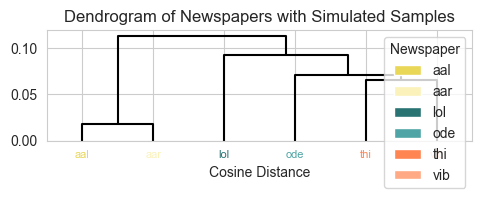

In [279]:
pivot_df_flat = pivot_df.reset_index()
plot_newspaper_dendrogram(pivot_df_flat, newspaper_to_color, figsize=(5,2))

In [287]:
def plot_bar_dendrogram_newspapers(df, newspaper_to_color, title="Dendrogram of Newspapers (Simulated and Real)", figsize=(20, 5)):
    """
    Plot a horizontal bar-colored dendrogram of newspapers based on cosine distances.
    
    Parameters:
    - df: DataFrame with 'newspaper' column and only numeric category columns.
    - newspaper_to_color: dict mapping each newspaper to a color.
    - title: plot title.
    - figsize: tuple with figure size.
    """
    # Extract labels
    newspaper_labels = df['newspaper'].values
    col_colors = pd.Series(newspaper_labels).map(newspaper_to_color).values

    # Prepare data matrix for cosine distance (exclude 'newspaper' column)
    matrix = df.drop(columns=['newspaper']).values
    dist_matrix = cosine_distances(matrix)

    # Compute linkage
    Z = linkage(dist_matrix, method='ward')

    # Plot clustermap with colored bars
    sns.set_theme(style="white")
    g = sns.clustermap(
        matrix.T,  # transpose to match color bars correctly
        col_linkage=Z,
        row_cluster=False,
        col_colors=col_colors,
        figsize=figsize,
        dendrogram_ratio=(0.01, 0.9),
        colors_ratio=0.04
    )

    # Remove heatmap and colorbar
    g.ax_heatmap.remove()
    g.cax.remove()

    # Build legend from used newspapers
    handles = [Patch(color=color, label=paper) for paper, color in newspaper_to_color.items()]
    g.ax_col_dendrogram.legend(handles=handles, loc='upper right', title='Newspaper', fontsize=9)

    # Add label and title
    g.fig.text(0.02, 0.6, "Cosine Distance", va='center', rotation='vertical', fontsize=12)
    g.fig.suptitle(title, y=1.02, fontsize=14)

    plt.show()

/var/folders/dt/1462j2zd19q_2sh2_66j7_8m6l1brz/T/ipykernel_1589/3265766790.py:20: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='ward')


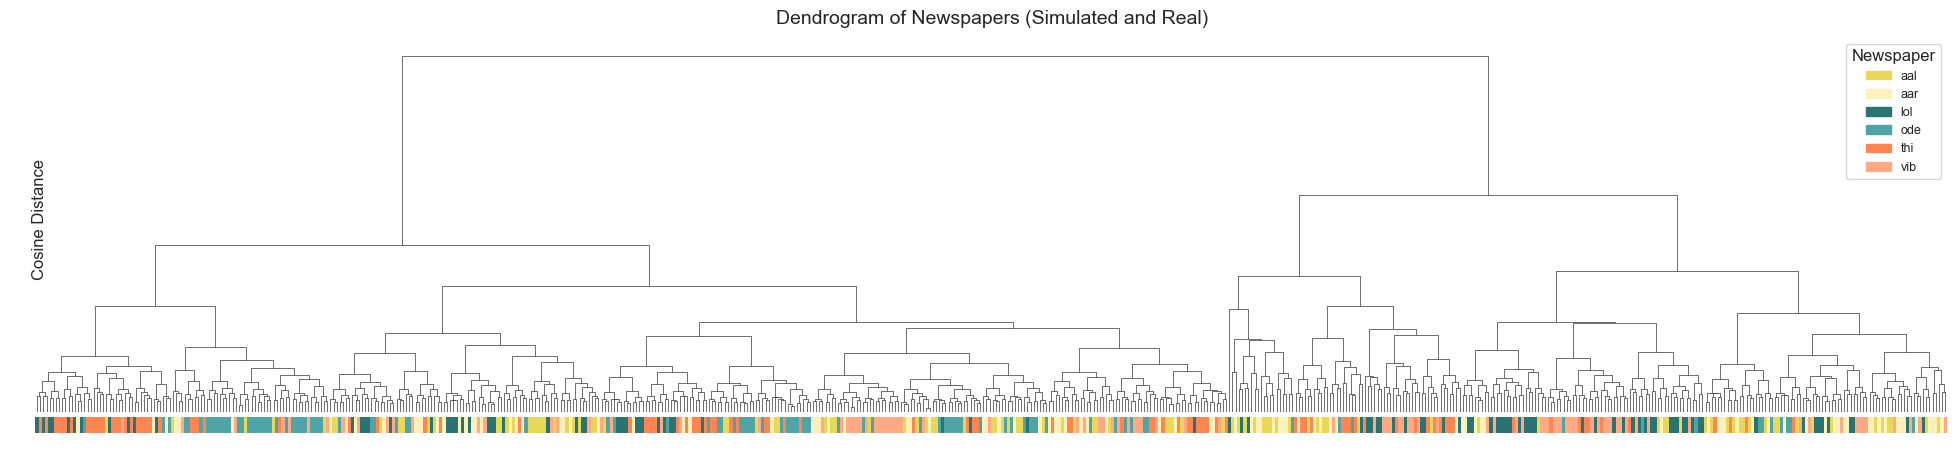

In [288]:
plot_bar_dendrogram_newspapers(total_df_flat, newspaper_to_color)

In [290]:
matrix = pivot_df_flat.drop(columns=['newspaper']).values
dist_matrix = cosine_distances(matrix)

In [291]:
dist_matrix

array([[0.        , 0.00557598, 0.04628976, 0.04940853, 0.045392  ,
        0.0470104 ],
       [0.00557598, 0.        , 0.06043659, 0.05042961, 0.05019813,
        0.04161362],
       [0.04628976, 0.06043659, 0.        , 0.07521748, 0.0416648 ,
        0.04710549],
       [0.04940853, 0.05042961, 0.07521748, 0.        , 0.04317018,
        0.04375911],
       [0.045392  , 0.05019813, 0.0416648 , 0.04317018, 0.        ,
        0.04535018],
       [0.0470104 , 0.04161362, 0.04710549, 0.04375911, 0.04535018,
        0.        ]])

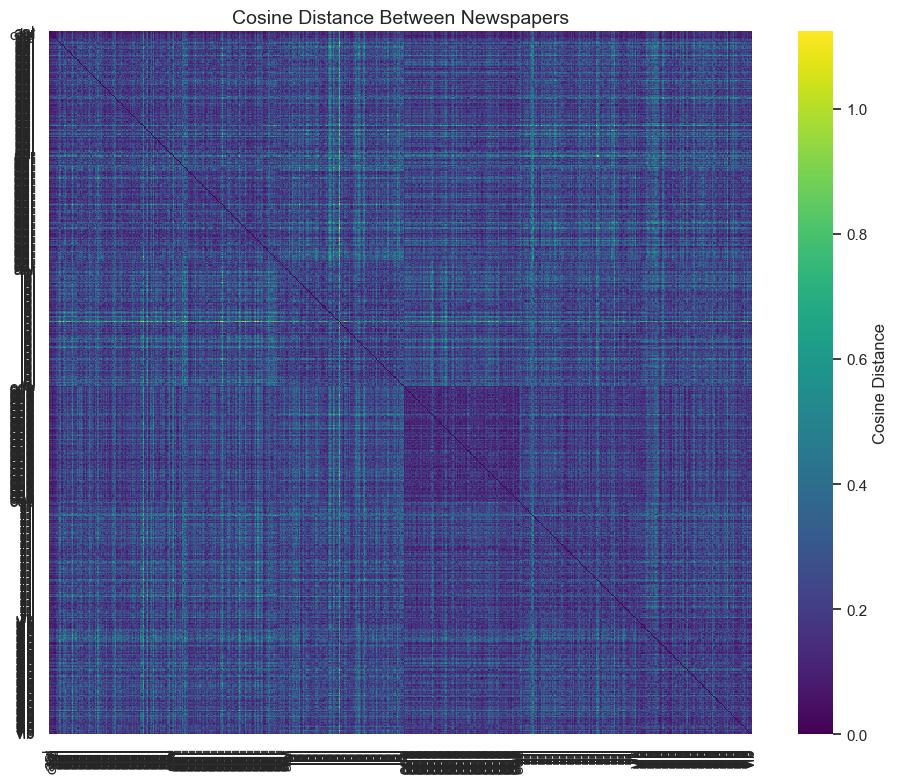

In [293]:
from sklearn.metrics.pairwise import cosine_distances

def plot_distance_heatmap(df, title="Cosine Distance Between Newspapers"):
    """
    Plot a heatmap of the cosine distance matrix for all newspaper vectors.
    Assumes 'newspaper' column exists in the dataframe.
    """
    # Extract vectors and labels
    labels = df['newspaper'].values
    matrix = df.drop(columns=['newspaper']).values

    # Compute cosine distance matrix
    dist_matrix = cosine_distances(matrix)

    # Create DataFrame for labeling
    dist_df = pd.DataFrame(dist_matrix, index=labels, columns=labels)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(dist_df, cmap='viridis', square=True, xticklabels=True, yticklabels=True, cbar_kws={'label': 'Cosine Distance'})
    plt.title(title, fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_distance_heatmap(total_df_flat)

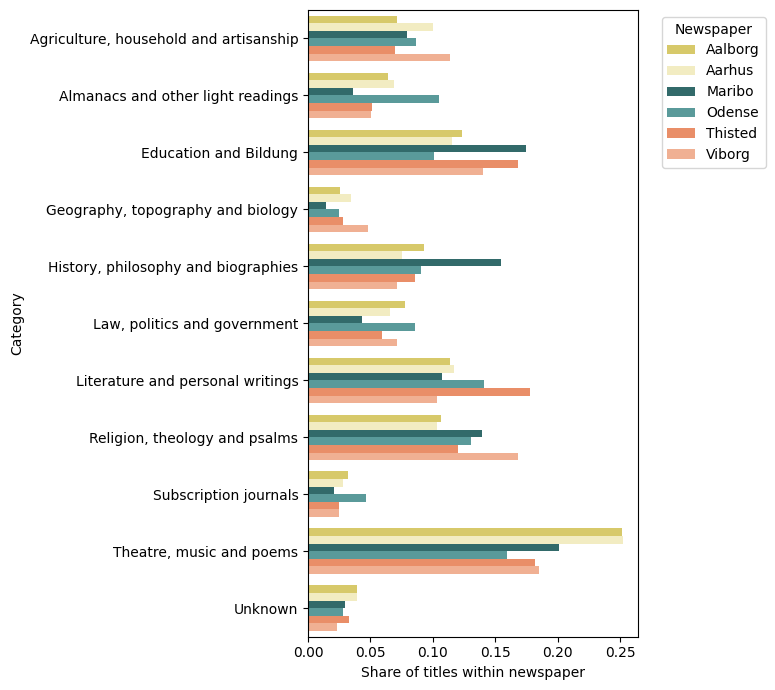

In [198]:
plt.figure(figsize=(8, 7))

legend_labels = {'aal': 'Aalborg',
                 'aar': 'Aarhus',
                 'lol': 'Maribo',
                 'ode': 'Odense',
                 'thi': 'Thisted',
                 'vib': 'Viborg'}

sns.barplot(
    data=category_shares,
    y='category',
    x='category_share',
    hue='newspaper',
    orient='h',
    palette=newspaper_to_color  # ✅ this applies your custom colors
)

plt.xlabel('Share of titles within newspaper')
plt.ylabel('Category')
#plt.title('Category distribution per newspaper')

# Get original handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Replace labels with custom ones
custom_labels = [legend_labels[label] for label in labels]

# Apply updated legend
plt.legend(handles, custom_labels, title='Newspaper', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../figures/horizontal_bars_cats.pdf', bbox_inches='tight')
plt.show()